# Имопрт всего, что нужно

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import nltk
import pandas as pd, re, itertools


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from pylab import rcParams
from matplotlib import rc
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from nltk import FreqDist, classify, NaiveBayesClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB


%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='muted')

Чтение датафрейма. Первые 1000 строк -- матариал для обучения, последние 200 -- для тестирования

In [ ]:
df = pd.read_csv('data.csv')
df['sentiment'] = pd.to_numeric(df['sentiment'])

# Информация о датасете

В тексте 1200 отзывов. Для теста -- 200 отзывов (99 положительных), для обучения 1000 отзывов (половина положительных)

Ниже построение графиков длин датасета по полярности до и после препроцессинга

In [ ]:
positive = df[df.sentiment==1]
negative = df[df.sentiment==-1]


legnth_positive_raw = sum(positive['content'].apply(len))
legnth_negative_raw = sum(negative['content'].apply(len))


legnth_positive_preprocessed = sum(positive['preprocessed'].apply(len))
legnth_negative_preprocessed = sum(negative['preprocessed'].apply(len))

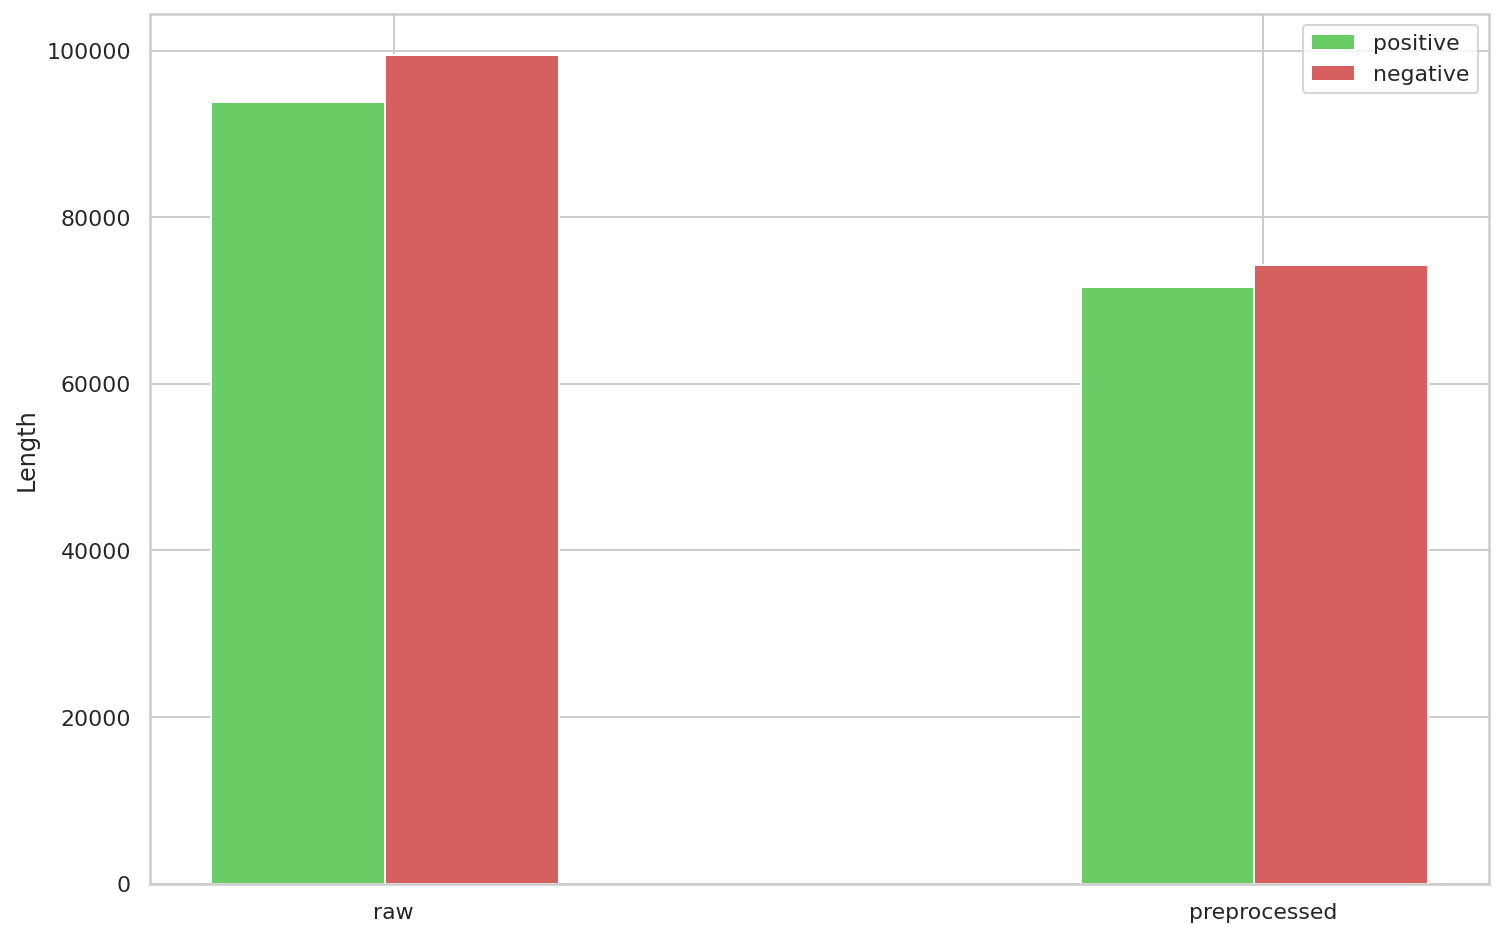

In [ ]:
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8))
 

positive = [legnth_positive_raw, legnth_positive_preprocessed]
negative = [legnth_negative_raw, legnth_negative_preprocessed]


br1 = np.arange(len(positive))
br2 = [x + barWidth for x in br1]


plt.bar(br1, positive, color ='g', width = barWidth, label ='positive')
plt.bar(br2, negative, color ='r', width = barWidth, label ='negative')


plt.ylabel('Length', fontsize = 12)
plt.xticks([r + 0.11 for r in range(len(positive))],
        ['raw', 'preprocessed'])
 

plt.legend()
plt.show()

# Обучение моделей на текстах

Функция построения важности слов для определения тональности отзыва и функция построения матрицы ошибок

In [ ]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, 
                               top_positive_coefficients])
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < top_features else 'blue' 
           for c in range(0, top_features*2)]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xlabel("Features")
 plt.ylabel("Feature coeficient")
 plt.title("Most important features")
 plt.xticks(np.arange(0.5, 0.5+2 * top_features), 
            feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

def plot_matrix(model, X_test, y_test):
  class_names = [-1, 1]
  titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
  for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
  plt.show()

Гридсерч по svm модели. Помимо параметров самой модели, происходит поиск оптимального метода векторизации

In [ ]:
svm_pipeline = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', LinearSVC())])


parameters_svm = {
                  'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2), (1,3), 
                                              (2,3)],
                  'clf__C': [1, 0.1, 0.01],
                  'tfidf__use_idf': (True, False),
                  'tfidf__smooth_idf': (True, False),
                  'tfidf__sublinear_tf': (True, False),
                  'clf__penalty': ('l1', 'l2'),
                  'clf__dual': (True, False),
                  'clf__loss': ('hinge', 'squared_hinge'),
                  'clf__class_weight': ('balanced', None)
               }


gs_clf_svm = GridSearchCV(svm_pipeline, parameters_svm, n_jobs=-1, 
                          scoring = "f1")
gs_clf_svm = gs_clf_svm.fit(df['preprocessed'][:1000], df['sentiment'][:1000])

F1-скор и параметры лучшей модели

In [ ]:
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.8811052802860522
{'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__dual': True, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2', 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 1)}


Инициализируем svm-модель с лучшими параметрами

In [ ]:
svm_model = LinearSVC(C=0.1, class_weight='balanced')

То же самое, но для логистической регрессии

In [ ]:
logreg_pipeline = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', LogisticRegression())])


parameters_logreg = {
                      'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2), (1,3), 
                                              (2,3)],
                      'clf__C': [1, 0.1, 0.01],
                      'tfidf__use_idf': (True, False),
                      'tfidf__smooth_idf': (True, False),
                      'tfidf__sublinear_tf': (True, False),
                      'clf__solver': ['liblinear'],
                      'clf__dual': (True, False),
                      'clf__penalty': ('l1', 'l2'),
                      'clf__class_weight': ('balanced', None)    
              }


gs_clf_logreg = GridSearchCV(logreg_pipeline, parameters_logreg, n_jobs=-1, 
                          scoring = "f1")
gs_clf_logreg = gs_clf_logreg.fit(df['preprocessed'][:1000], 
                                  df['sentiment'][:1000])

In [ ]:
print(gs_clf_logreg.best_score_)
print(gs_clf_logreg.best_params_)

0.8775077324868235
{'clf': LogisticRegression(C=1, class_weight='balanced', dual=True, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__dual': True, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 1)}


In [ ]:
logreg_model = LogisticRegression(class_weight='balanced', dual=True, 
                                  solver='liblinear')

Параметры векторайзера для обоих моделей оказались одинаковыми, поэтому инициализируем его. Он будет общий для двух моделей

In [ ]:
vectorizer = TfidfVectorizer(smooth_idf=False, sublinear_tf=True)

In [ ]:
vectorizer.fit(df['preprocessed'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=False, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

Как уже было сказано, первые 1000 отзывов -- для обучения; последние 200 -- для тестирования

In [ ]:
X_train = vectorizer.transform(df['preprocessed'][:1000])
X_test = vectorizer.transform(df['preprocessed'][1000:])

Построим график важности слов для svm

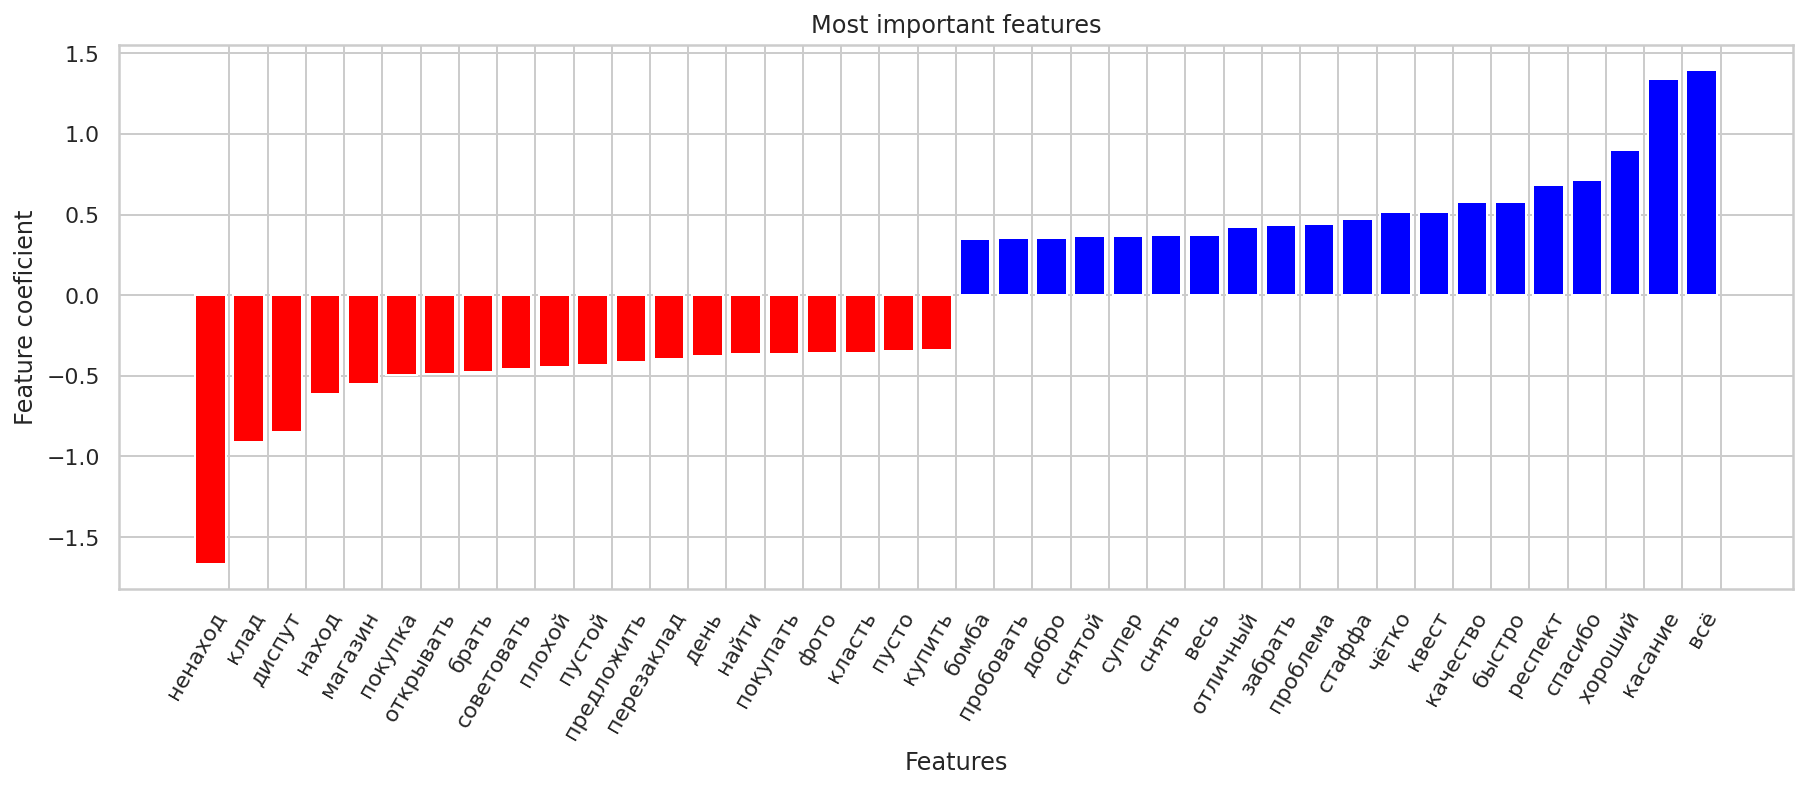

In [ ]:
svm_model.fit(X_train, df['sentiment'][:1000])
plot_coefficients(svm_model, vectorizer.get_feature_names())

Посмотрим на результаты для тестового набора данных

In [ ]:
prediction_svm = svm_model.predict(X_test)
classification_report(df['sentiment'][1000:], prediction_svm, 
                      output_dict=True)

{'-1': {'f1-score': 0.9183673469387755,
  'precision': 0.9473684210526315,
  'recall': 0.8910891089108911,
  'support': 101},
 '1': {'f1-score': 0.9215686274509803,
  'precision': 0.8952380952380953,
  'recall': 0.9494949494949495,
  'support': 99},
 'accuracy': 0.92,
 'macro avg': {'f1-score': 0.9199679871948779,
  'precision': 0.9213032581453634,
  'recall': 0.9202920292029203,
  'support': 200},
 'weighted avg': {'f1-score': 0.919951980792317,
  'precision': 0.921563909774436,
  'recall': 0.92,
  'support': 200}}

Матрица ошибок

Confusion matrix, without normalization
[[90 11]
 [ 5 94]]
Normalized confusion matrix
[[0.89108911 0.10891089]
 [0.05050505 0.94949495]]


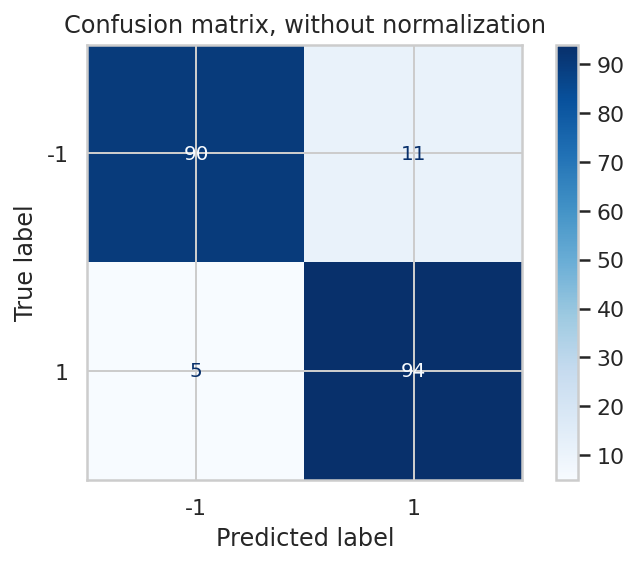

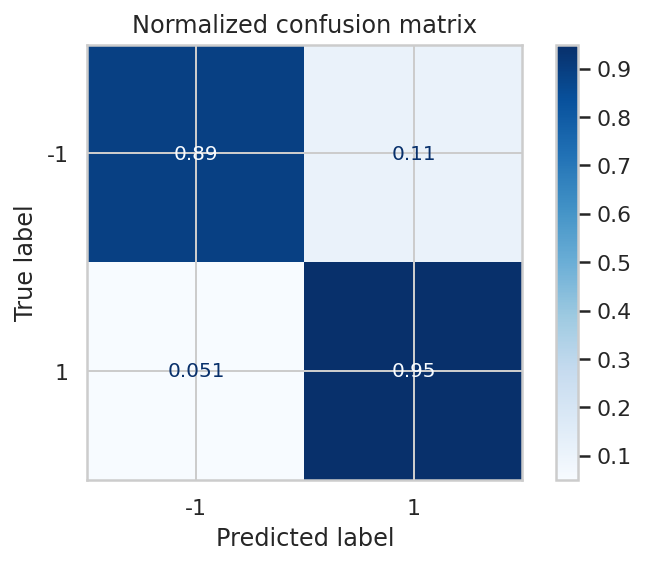

In [ ]:
plot_matrix(svm_model, X_test, df['sentiment'][1000:])

То же самое для логистической регрессии

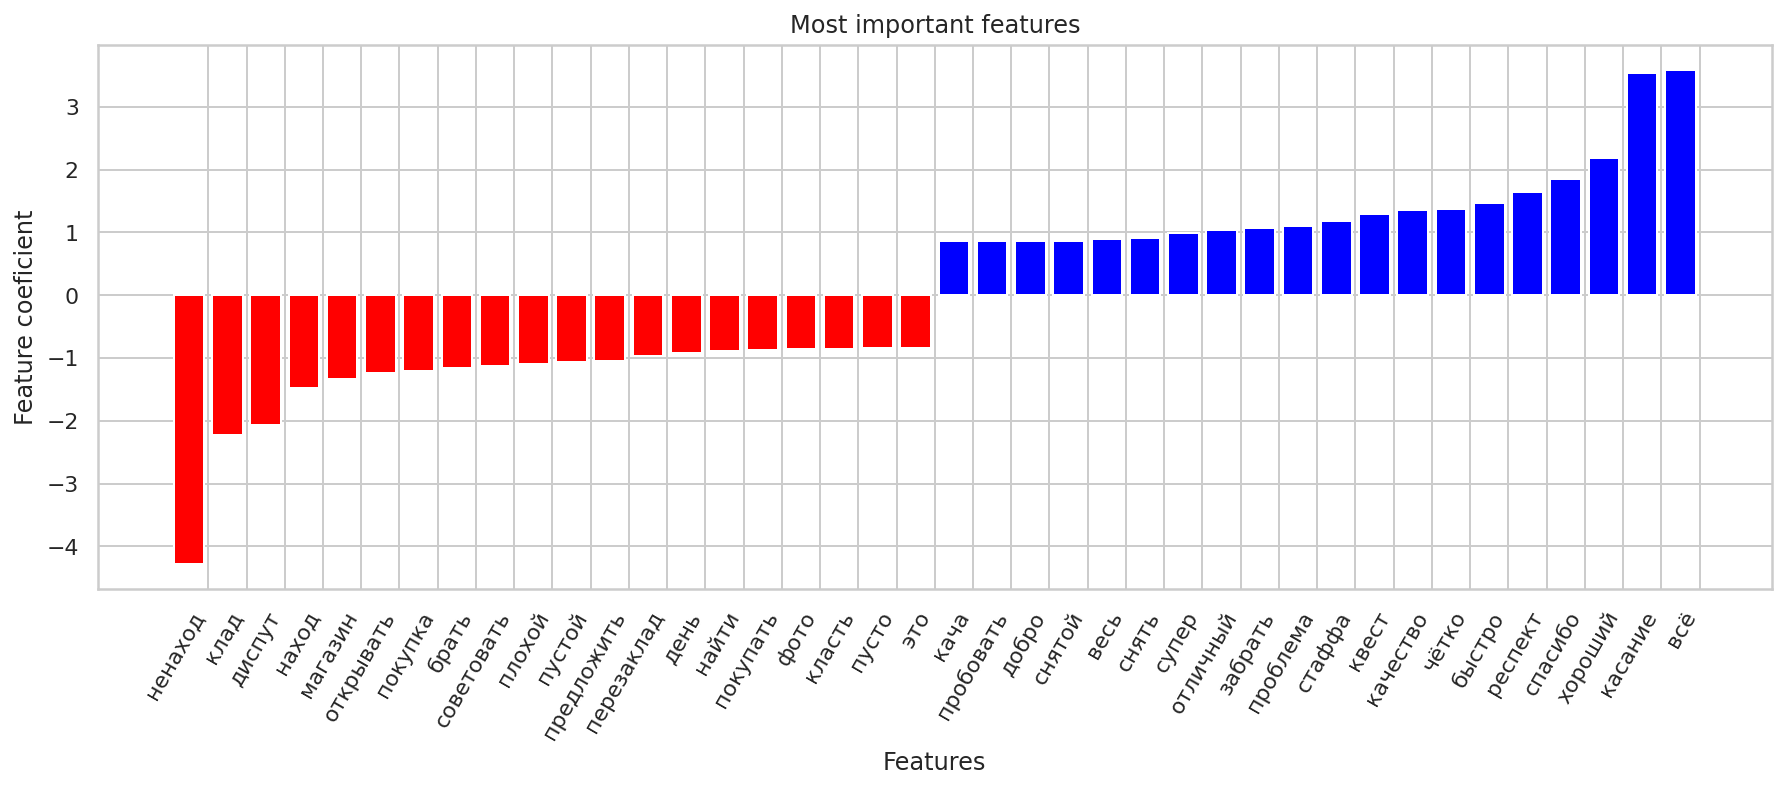

In [ ]:
logreg_model.fit(X_train, df['sentiment'][:1000])
plot_coefficients(logreg_model, vectorizer.get_feature_names())

In [ ]:
prediction_logreg = logreg_model.predict(X_test)
classification_report(df['sentiment'][1000:], prediction_logreg, 
                      output_dict=True)

{'-1': {'f1-score': 0.9238578680203046,
  'precision': 0.9479166666666666,
  'recall': 0.900990099009901,
  'support': 101},
 '1': {'f1-score': 0.9261083743842364,
  'precision': 0.9038461538461539,
  'recall': 0.9494949494949495,
  'support': 99},
 'accuracy': 0.925,
 'macro avg': {'f1-score': 0.9249831212022706,
  'precision': 0.9258814102564102,
  'recall': 0.9252425242524253,
  'support': 200},
 'weighted avg': {'f1-score': 0.9249718686704509,
  'precision': 0.9261017628205127,
  'recall': 0.925,
  'support': 200}}

Confusion matrix, without normalization
[[91 10]
 [ 5 94]]
Normalized confusion matrix
[[0.9009901  0.0990099 ]
 [0.05050505 0.94949495]]


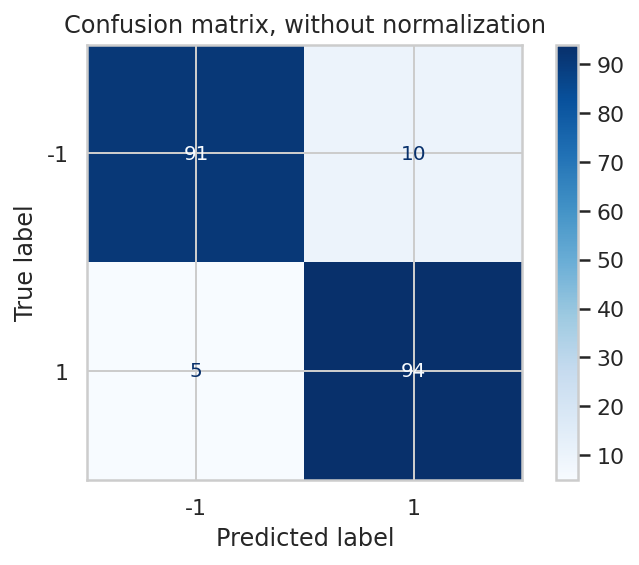

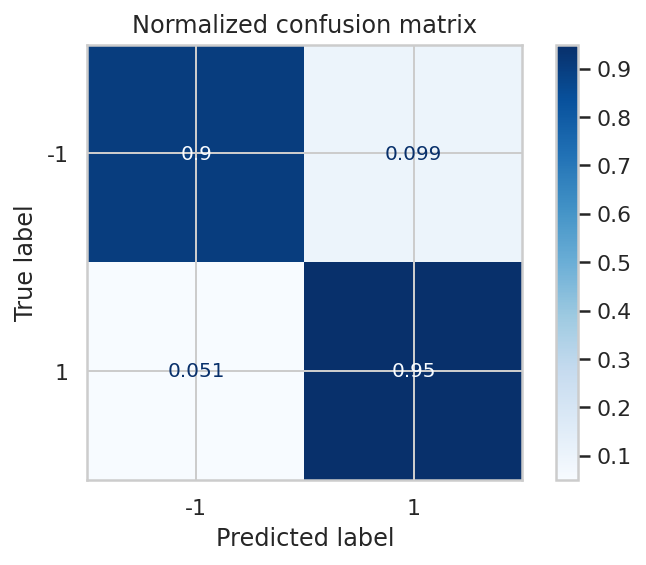

In [ ]:
plot_matrix(logreg_model, X_test, df['sentiment'][1000:])

# Обучение моделей на частеречных тэгах

Обучим таким же способом две модели определять тональность отзыва по частям речи

In [ ]:
svm_pipeline_pos = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', LinearSVC())])


gs_clf_svm_pos = GridSearchCV(svm_pipeline_pos, parameters_svm, n_jobs=-1, 
                          scoring = "f1")
gs_clf_svm_pos = gs_clf_svm_pos.fit(df['pos_tags'][:1000], df['sentiment'][:1000])

In [ ]:
print(gs_clf_svm_pos.best_score_)
print(gs_clf_svm_pos.best_params_)

0.7354310420755713
{'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__dual': True, 'clf__loss': 'hinge', 'clf__penalty': 'l2', 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 3)}


In [ ]:
svm_model_pos = LinearSVC(C=0.1, class_weight='balanced', loss='hinge')
vectorizer_svm_pos = TfidfVectorizer(sublinear_tf=True, smooth_idf=False, 
                                     ngram_range=(1,3))

In [ ]:
vectorizer_svm_pos.fit(df['pos_tags'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=False, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
X_train_pos = vectorizer_svm_pos.transform(df['pos_tags'][:1000])
X_test_pos = vectorizer_svm_pos.transform(df['pos_tags'][1000:])

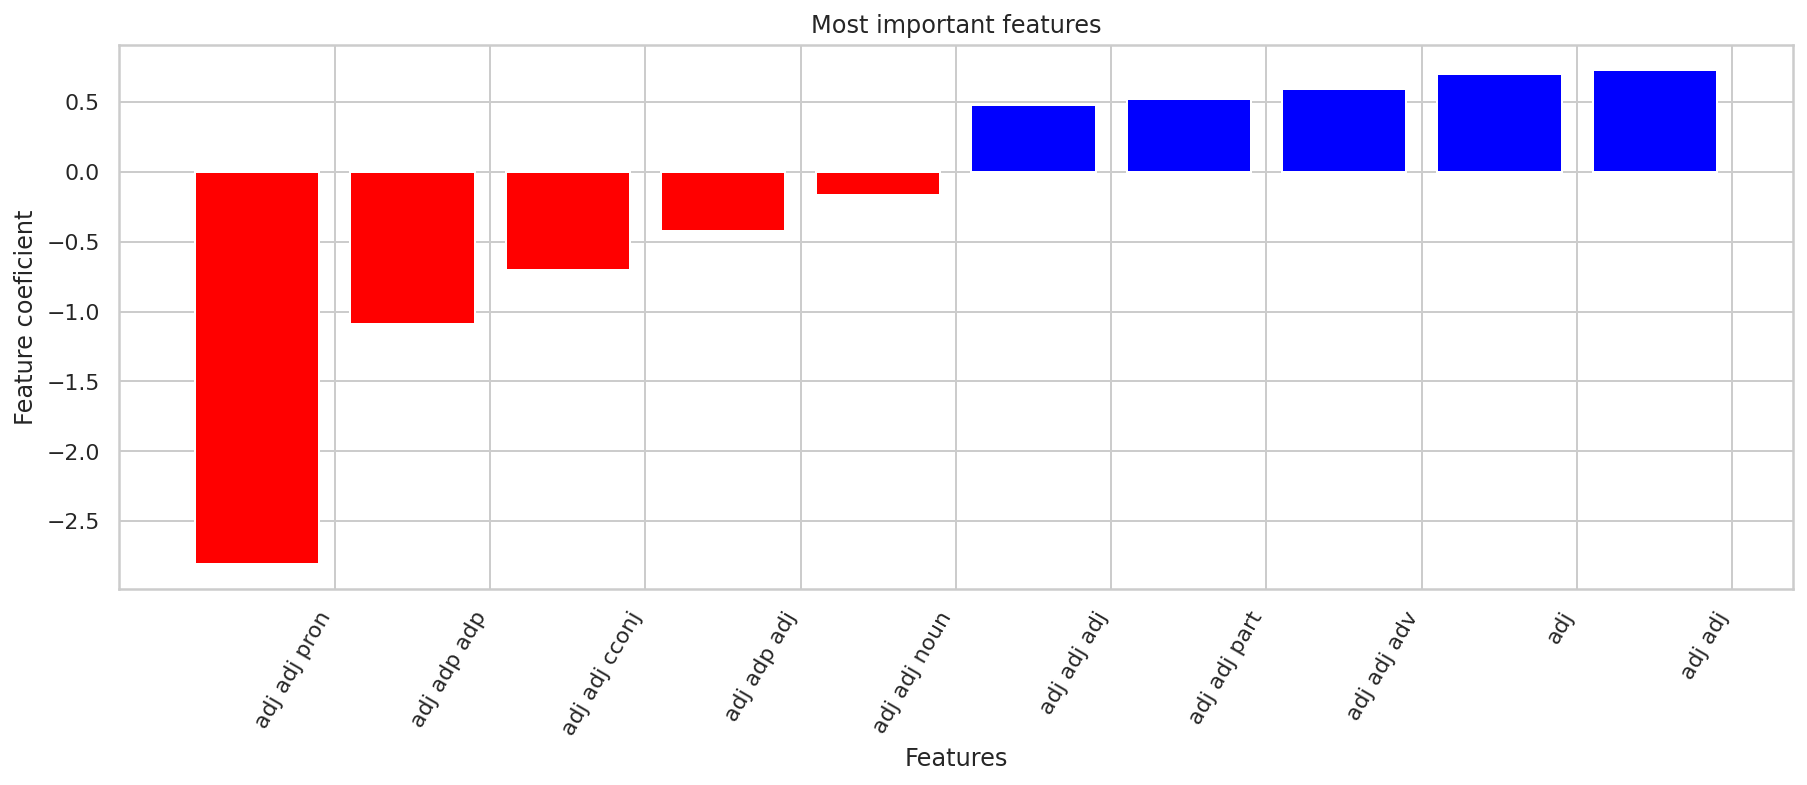

In [ ]:
svm_model_pos.fit(X_train_pos, df['sentiment'][:1000])
plot_coefficients(svm_model_pos, vectorizer_svm_pos.get_feature_names(), 
                  top_features=5)

In [ ]:
prediction_svm_pos = svm_model_pos.predict(X_test_pos)
classification_report(df['sentiment'][1000:], prediction_svm_pos, 
                      output_dict=True)

{'-1': {'f1-score': 0.6666666666666667,
  'precision': 0.7159090909090909,
  'recall': 0.6237623762376238,
  'support': 101},
 '1': {'f1-score': 0.7014218009478673,
  'precision': 0.6607142857142857,
  'recall': 0.7474747474747475,
  'support': 99},
 'accuracy': 0.685,
 'macro avg': {'f1-score': 0.684044233807267,
  'precision': 0.6883116883116883,
  'recall': 0.6856185618561856,
  'support': 200},
 'weighted avg': {'f1-score': 0.683870458135861,
  'precision': 0.6885876623376623,
  'recall': 0.685,
  'support': 200}}

Confusion matrix, without normalization
[[60 41]
 [28 71]]
Normalized confusion matrix
[[0.59405941 0.40594059]
 [0.28282828 0.71717172]]


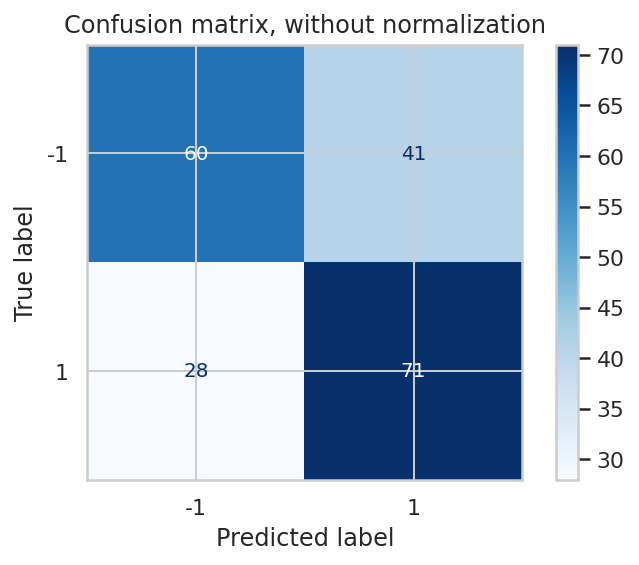

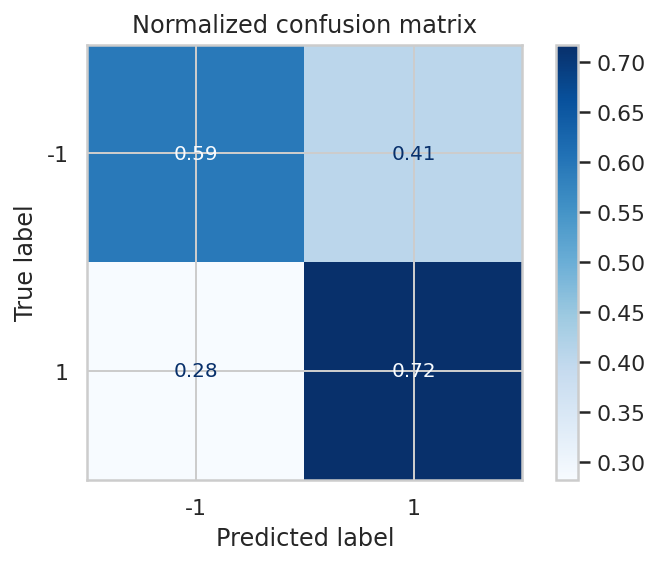

In [ ]:
plot_matrix(svm_model_pos, X_test_pos, df['sentiment'][1000:])

In [ ]:
logreg_pipeline_pos = Pipeline([('vectorizer', CountVectorizer()),
 ('tfidf', TfidfTransformer()),
 ('clf', LogisticRegression())])


gs_clf_logreg_pos = GridSearchCV(logreg_pipeline_pos, parameters_logreg, 
                                 n_jobs=-1, scoring = "f1")
gs_clf_logreg_pos = gs_clf_logreg_pos.fit(df['preprocessed'][:1000], 
                                          df['sentiment'][:1000])

In [ ]:
print(gs_clf_logreg_pos.best_score_)
print(gs_clf_logreg_pos.best_params_)

0.8775077324868235
{'clf': LogisticRegression(C=1, class_weight='balanced', dual=True, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__dual': True, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vectorizer__ngram_range': (1, 1)}


In [ ]:
logreg_model_pos = LogisticRegression(class_weight='balanced', 
                                      solver='liblinear', dual=True)
vectorizer_logreg_pos = TfidfVectorizer(smooth_idf=False, sublinear_tf=True)

In [ ]:
vectorizer_logreg_pos.fit(df['pos_tags'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=False, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
X_train_pos = vectorizer_logreg_pos.transform(df['pos_tags'][:1000])
X_test_pos = vectorizer_logreg_pos.transform(df['pos_tags'][1000:])

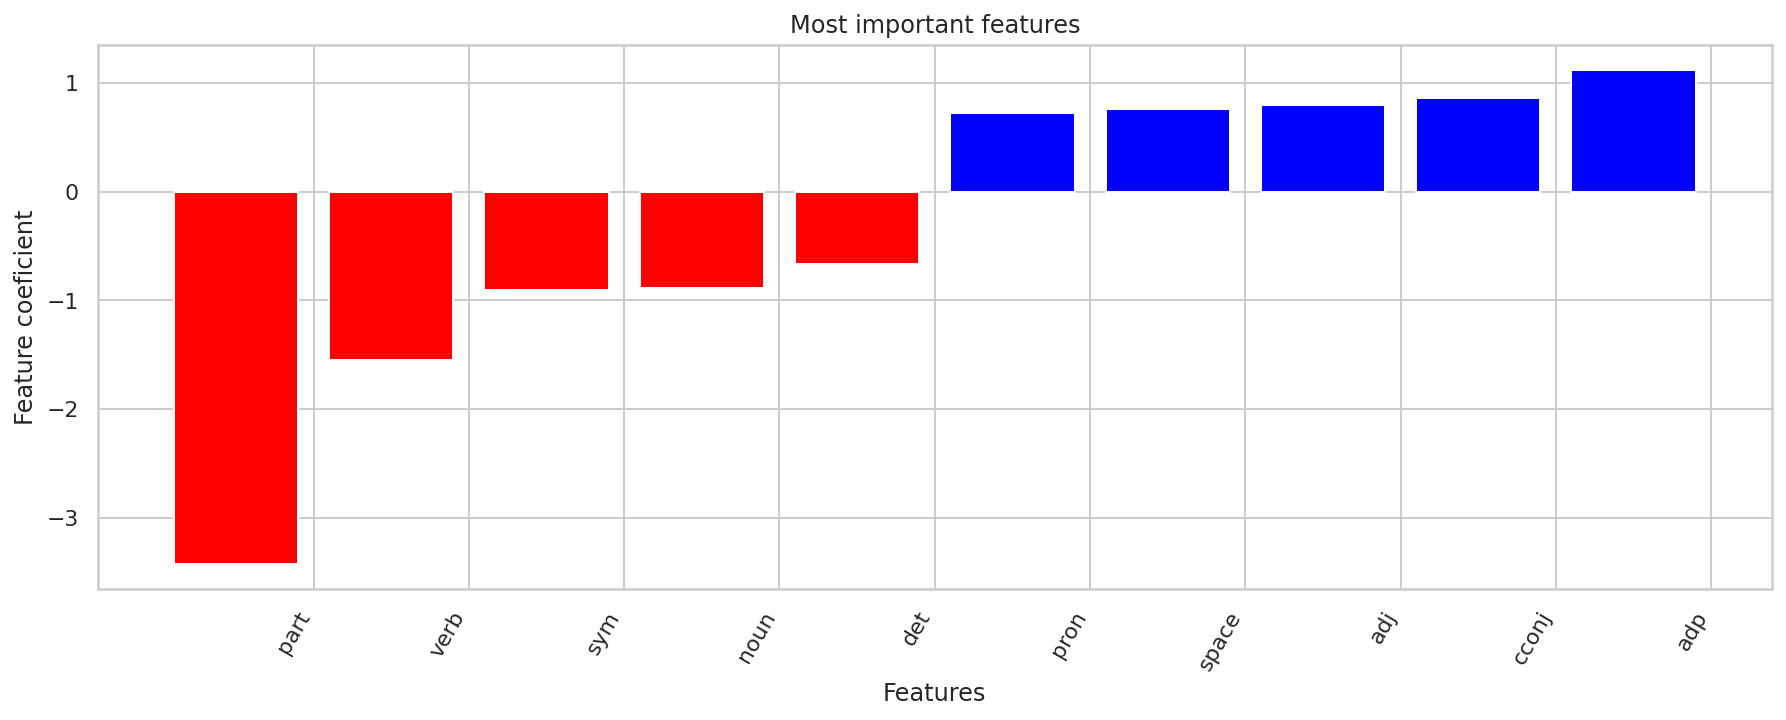

In [ ]:
logreg_model_pos.fit(X_train_pos, df['sentiment'][:1000])
plot_coefficients(logreg_model_pos, vectorizer_logreg_pos.get_feature_names(), 
                  top_features=5)

In [ ]:
prediction_logreg_pos = logreg_model_pos.predict(X_test_pos)
classification_report(df['sentiment'][1000:], prediction_logreg_pos, 
                      output_dict=True)

{'-1': {'f1-score': 0.6494845360824741,
  'precision': 0.6774193548387096,
  'recall': 0.6237623762376238,
  'support': 101},
 '1': {'f1-score': 0.6699029126213593,
  'precision': 0.6448598130841121,
  'recall': 0.696969696969697,
  'support': 99},
 'accuracy': 0.66,
 'macro avg': {'f1-score': 0.6596937243519168,
  'precision': 0.6611395839614109,
  'recall': 0.6603660366036603,
  'support': 200},
 'weighted avg': {'f1-score': 0.6595916324692223,
  'precision': 0.661302381670184,
  'recall': 0.66,
  'support': 200}}

Confusion matrix, without normalization
[[63 38]
 [30 69]]
Normalized confusion matrix
[[0.62376238 0.37623762]
 [0.3030303  0.6969697 ]]


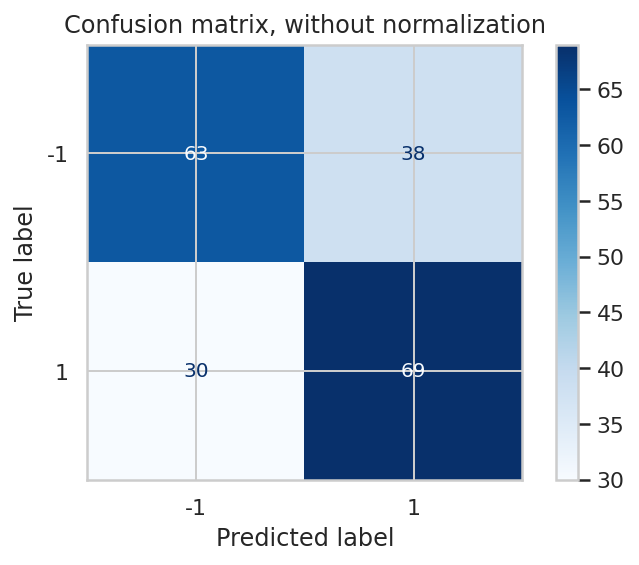

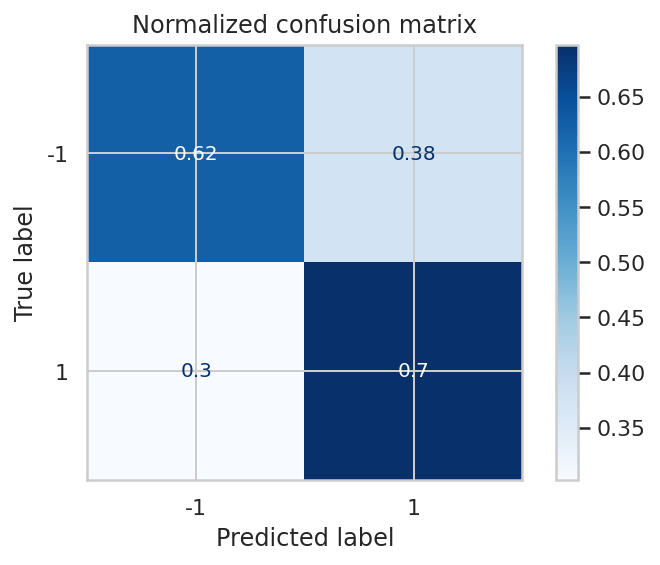

In [ ]:
plot_matrix(logreg_model_pos, X_test_pos, df['sentiment'][1000:])